# Load Data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import os
import matplotlib.pyplot as plt

# sklearn
import sklearn
from sklearn.svm import SVC
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, accuracy_score, confusion_matrix, roc_curve, make_scorer, f1_score
from scipy.stats import zscore, pearsonr, uniform
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, StratifiedKFold, RandomizedSearchCV, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler

from scipy.io import loadmat


# XGB
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier

# Neural Network - Tensorflow and more
from sklearn.datasets import make_blobs
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.ops import exp
import tensorflow.keras.backend as K

# from lab_utils_multiclass_TF import *
import logging
import gc

# tf.compat.v2.enable_eager_execution()
#make it non greedy inital allocation
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)
              
'''
import tensorflow.compat.v1 as tf # V2.x
tf.disable_v2_behavior()
print(tf.__version__, keras.__version__)
'''

2025-03-18 10:15:11.112859: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-18 10:15:11.122357: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742307311.133570   77785 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742307311.136342   77785 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742307311.143956   77785 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

'\nimport tensorflow.compat.v1 as tf # V2.x\ntf.disable_v2_behavior()\nprint(tf.__version__, keras.__version__)\n'

In [2]:
# load training data as dataframes - quantitative
file_path_trainquant = '/mnt/c/Users/Robbie/Desktop/VSCode/WiDS/widsdatathon2025/TRAIN/TRAIN_QUANTITATIVE_METADATA.xlsx'
trainquant_pre = pd.read_excel(file_path_trainquant)

# load training data as dataframes - categorical
file_path_traincat = '/mnt/c/Users/Robbie/Desktop/VSCode/WiDS/widsdatathon2025/TRAIN/TRAIN_CATEGORICAL_METADATA.xlsx'
traincat_pre = pd.read_excel(file_path_traincat)

# load training data as dataframes - fMRI matrices (functional connectome matrices)
file_path_trainFCM = '/mnt/c/Users/Robbie/Desktop/VSCode/WiDS/widsdatathon2025/TRAIN/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES.csv'
trainFCM = pd.read_csv(file_path_trainFCM)

# load training data as dataframes - ADHD and Sex Solutions
file_path_trainsol = '/mnt/c/Users/Robbie/Desktop/VSCode/WiDS/widsdatathon2025/TRAIN/TRAINING_SOLUTIONS.xlsx'
trainsol = pd.read_excel(file_path_trainsol)

# load test data as dataframes - quantitative
file_path_testquant = "/mnt/c/Users/Robbie/Desktop/VSCode/WiDS/widsdatathon2025/TEST/TEST_QUANTITATIVE_METADATA.xlsx"
testquant_pre = pd.read_excel(file_path_testquant)

# load test data as dataframes - categorical
file_path_testcat = "/mnt/c/Users/Robbie/Desktop/VSCode/WiDS/widsdatathon2025/TEST/TEST_CATEGORICAL.xlsx"
testcat_pre = pd.read_excel(file_path_testcat)

# load test data as dataframes - fMRI matrices
file_path_testFCM = "/mnt/c/Users/Robbie/Desktop/VSCode/WiDS/widsdatathon2025/TEST/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv"
testFCM = pd.read_csv(file_path_testFCM)

In [3]:
print(trainFCM.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1213 entries, 0 to 1212
Columns: 19901 entries, participant_id to 198throw_199thcolumn
dtypes: float64(19900), object(1)
memory usage: 184.2+ MB
None


# Exploratory Data Analysis

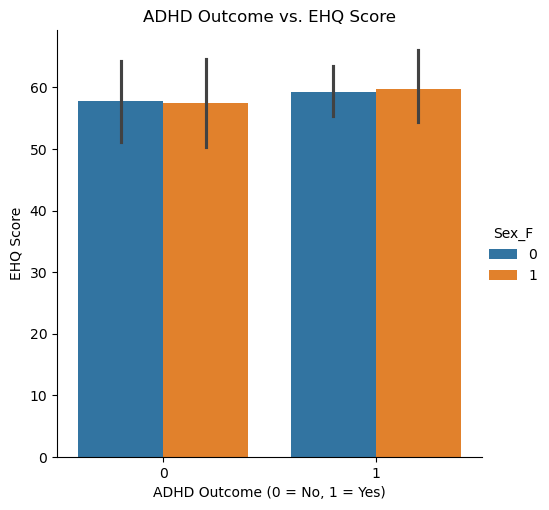

In [4]:
trainQuantSol = pd.merge(trainsol, trainquant_pre, how = 'inner', on = 'participant_id')
sns.catplot(data= trainQuantSol, kind = 'bar', x= 'ADHD_Outcome', y = 'EHQ_EHQ_Total', hue = 'Sex_F')
plt.title('ADHD Outcome vs. EHQ Score')
plt.xlabel('ADHD Outcome (0 = No, 1 = Yes)')
plt.ylabel('EHQ Score')
plt.show()

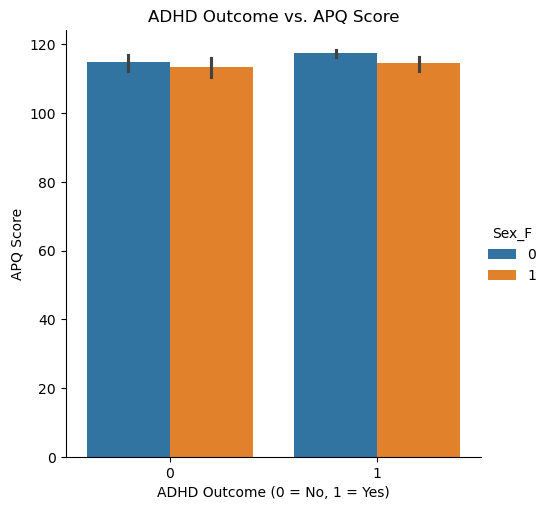

In [9]:
APQ_Total = trainQuantSol.iloc[:, 5:11]
trainQuantSol = trainQuantSol.assign(APQ_Total = APQ_Total.sum(axis=1))
sns.catplot(data= trainQuantSol, kind = 'bar', x= 'ADHD_Outcome', y = 'APQ_Total', hue = 'Sex_F')
plt.title('ADHD Outcome vs. APQ Score')
plt.xlabel('ADHD Outcome (0 = No, 1 = Yes)')
plt.ylabel('APQ Score')
plt.show()

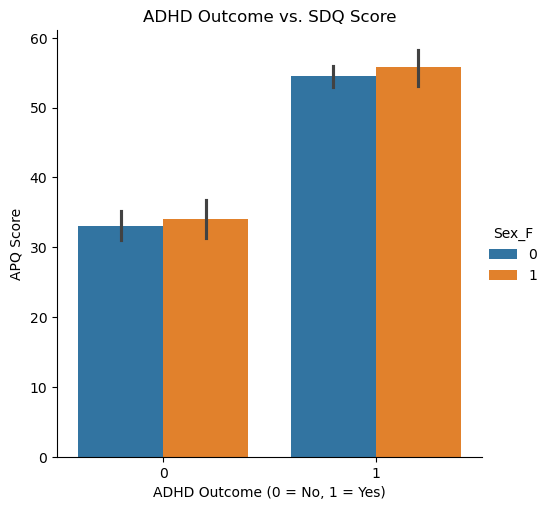

In [10]:
SDQ_Total = trainQuantSol.iloc[:, 11:20]
trainQuantSol = trainQuantSol.assign(SDQ_Total = SDQ_Total.sum(axis=1))
sns.catplot(data= trainQuantSol, kind = 'bar', x= 'ADHD_Outcome', y = 'SDQ_Total', hue = 'Sex_F')
plt.title('ADHD Outcome vs. SDQ Score')
plt.xlabel('ADHD Outcome (0 = No, 1 = Yes)')
plt.ylabel('APQ Score')
plt.show()

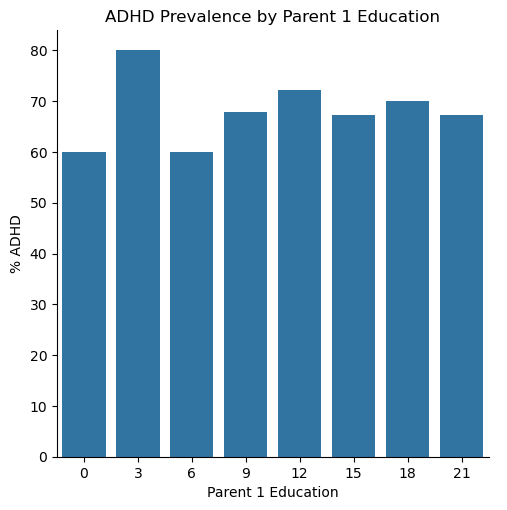

In [13]:
# taking a closer look at categorical data
# Parent 1 Education
trainCatSol = pd.merge(trainsol, traincat_pre, how = 'inner', on = 'participant_id')
P1Edu_ADHD = trainCatSol.groupby(['Barratt_Barratt_P1_Edu'], as_index = False).sum()
P1_Edu_counts = traincat_pre['Barratt_Barratt_P1_Edu'].value_counts().sort_index().set_axis([0,1,2,3,4,5,6,7])
P1Edu_ADHD = P1Edu_ADHD.assign(ADHD_Percent = 100 * P1Edu_ADHD['ADHD_Outcome']/P1_Edu_counts)

sns.catplot(data=P1Edu_ADHD, kind = 'bar', x= 'Barratt_Barratt_P1_Edu', y = 'ADHD_Percent')
plt.title('ADHD Prevalence by Parent 1 Education')
plt.xlabel('Parent 1 Education')
plt.ylabel('% ADHD')
plt.show()
# is a value of 0 null?
# "3=Less than 7th grade, 6=Junior high/Middle school (9th grade), 9=Partial high school (10th or 11th grade), 12=High school graduate, 15=Partial college (at least one year), 18=College education, 21=Graduate degree"

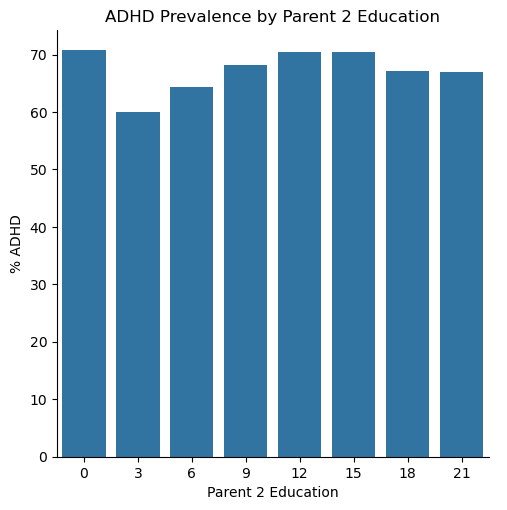

In [15]:
# Parent 2 Education
P2Edu_ADHD = trainCatSol.groupby(['Barratt_Barratt_P2_Edu'], as_index = False).sum()
P2_Edu_counts = traincat_pre['Barratt_Barratt_P2_Edu'].value_counts().sort_index().set_axis([0,1,2,3,4,5,6,7])
P2Edu_ADHD = P2Edu_ADHD.assign(ADHD_Percent = 100 * P2Edu_ADHD['ADHD_Outcome']/P2_Edu_counts)

sns.catplot(data=P2Edu_ADHD, kind = 'bar', x= 'Barratt_Barratt_P2_Edu', y = 'ADHD_Percent')
plt.title('ADHD Prevalence by Parent 2 Education')
plt.xlabel('Parent 2 Education')
plt.ylabel('% ADHD')
plt.show()

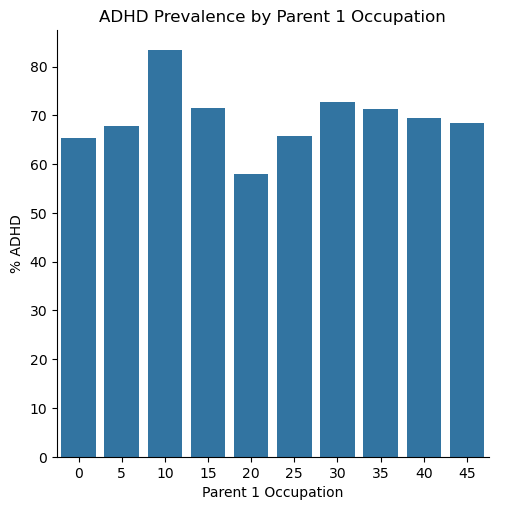

In [16]:
# Parent 1 Occupation
P1Occ_ADHD = trainCatSol.groupby(['Barratt_Barratt_P1_Occ'], as_index = False).sum()
P1_Occ_counts = traincat_pre['Barratt_Barratt_P1_Occ'].value_counts().sort_index().set_axis([0,1,2,3,4,5,6,7, 8, 9])
P1Occ_ADHD = P1Occ_ADHD.assign(ADHD_Percent = 100 * P1Occ_ADHD['ADHD_Outcome']/P1_Occ_counts)

sns.catplot(data=P1Occ_ADHD, kind = 'bar', x= 'Barratt_Barratt_P1_Occ', y = 'ADHD_Percent')
plt.title('ADHD Prevalence by Parent 1 Occupation')
plt.xlabel('Parent 1 Occupation')
plt.ylabel('% ADHD')
plt.show()

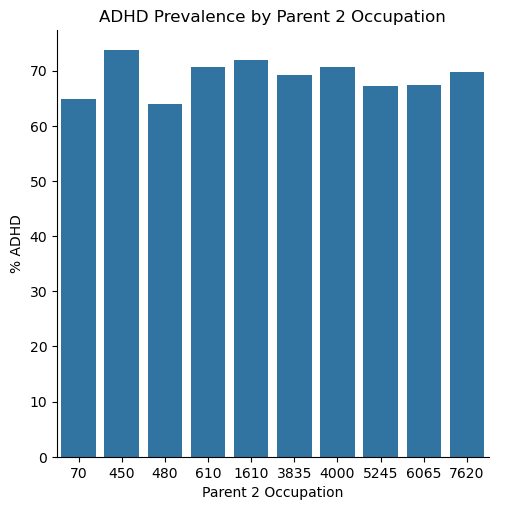

In [17]:
# Parent 2 Occupation
P2Occ_ADHD = trainCatSol.groupby(['Barratt_Barratt_P2_Occ'], as_index = False).sum()
P2_Occ_counts = traincat_pre['Barratt_Barratt_P2_Occ'].value_counts().sort_index().set_axis([0,1,2,3,4,5,6,7, 8, 9])
P2Occ_ADHD = P1Occ_ADHD.assign(ADHD_Percent = 100 * P2Occ_ADHD['ADHD_Outcome']/P2_Occ_counts)

sns.catplot(data=P2Occ_ADHD, kind = 'bar', x= 'Barratt_Barratt_P2_Occ', y = 'ADHD_Percent')
plt.title('ADHD Prevalence by Parent 2 Occupation')
plt.xlabel('Parent 2 Occupation')
plt.ylabel('% ADHD')
plt.show()

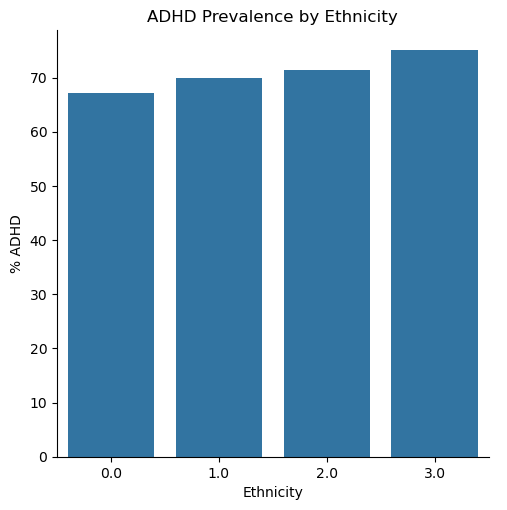

In [18]:
# Pre-Interview- Demographics/Family Ethnicity
Ethnicity_ADHD = trainCatSol.groupby(['PreInt_Demos_Fam_Child_Ethnicity'], as_index = False).sum()
Ethnicity_counts = traincat_pre['PreInt_Demos_Fam_Child_Ethnicity'].value_counts().sort_index().set_axis([0,1,2,3])
Ethnicity_ADHD = Ethnicity_ADHD.assign(ADHD_Percent = 100 * Ethnicity_ADHD['ADHD_Outcome']/Ethnicity_counts)

sns.catplot(data=Ethnicity_ADHD, kind = 'bar', x= 'PreInt_Demos_Fam_Child_Ethnicity', y = 'ADHD_Percent')
plt.title('ADHD Prevalence by Ethnicity')
plt.xlabel('Ethnicity')
plt.ylabel('% ADHD')
plt.show()
# "0= Not Hispanic or Latino, 1= Hispanic or Latino, 2= Decline to specify, 3= Unknown"

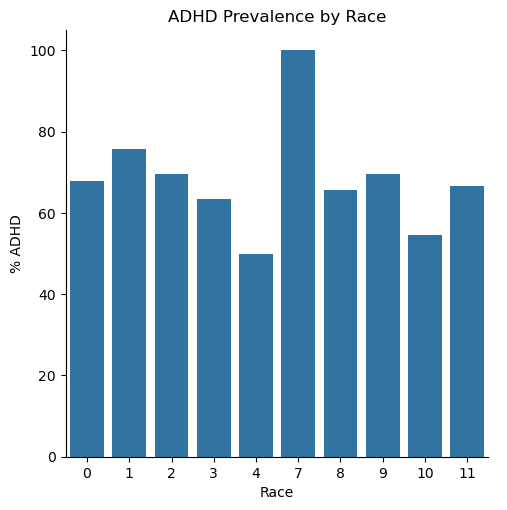

PreInt_Demos_Fam_Child_Race
0     627
1     181
2     128
3      30
4      10
7       2
8     195
9      23
10     11
11      6
Name: count, dtype: int64


In [21]:
# Pre-Interview- Demographics/Family Race
Race_ADHD = trainCatSol.groupby(['PreInt_Demos_Fam_Child_Race'], as_index = False).sum()
Race_counts = traincat_pre['PreInt_Demos_Fam_Child_Race'].value_counts().sort_index().set_axis([0,1,2,3,4,5,6,7,8,9])
Race_ADHD = Race_ADHD.assign(ADHD_Percent = 100 * Race_ADHD['ADHD_Outcome']/Race_counts)

sns.catplot(data=Race_ADHD, kind = 'bar', x= 'PreInt_Demos_Fam_Child_Race', y = 'ADHD_Percent')
plt.title('ADHD Prevalence by Race')
plt.xlabel('Race')
plt.ylabel('% ADHD')
plt.show()

print(traincat_pre['PreInt_Demos_Fam_Child_Race'].value_counts().sort_index())
# 0= White/Caucasian, 1= Black/African American, 2= Hispanic, 3= Asian, 4= Indian, 5= Native American Indian, 6= American Indian/Alaskan Native
# 7= Native Hawaiian/Other Pacific Islander,8= Two or more races, 9= Other race, 10= Unknown, 11=Choose not to specify

# Process Data

## Preliminary Feature Selection

In [5]:
# based on the exploratory data analysis, here are the features I want to drop
cat_to_drop = ['Basic_Demos_Enroll_Year', 'Basic_Demos_Study_Site', 'MRI_Track_Scan_Location', ]

traincat = traincat_pre.drop(columns = cat_to_drop)
testcat = testcat_pre.drop(columns = cat_to_drop)

quant_to_drop = ['EHQ_EHQ_Total', 'ColorVision_CV_Score', 'APQ_P_APQ_P_CP', 'APQ_P_APQ_P_ID', 'APQ_P_APQ_P_INV', 'APQ_P_APQ_P_OPD', 'APQ_P_APQ_P_PM', 'APQ_P_APQ_P_PP', 'MRI_Track_Age_at_Scan']

trainquant = trainquant_pre.drop(columns = quant_to_drop)
testquant = testquant_pre.drop(columns = quant_to_drop)

## Perform Feature Scaling

In [6]:
# perform feature scaling on train data 
columns_to_scale = trainquant.columns[1:].tolist() # don't want to scale participant id

# scale quantitative data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(trainquant[columns_to_scale])
scaled_trainquant = pd.DataFrame(scaled_data, columns = columns_to_scale)

# combine scaled columns with participant id again
trainquant_final = pd.concat([trainquant.drop(columns=columns_to_scale), scaled_trainquant], axis=1)

# perform feature scaling on test data
columns_to_scale2 = testquant.columns[1:].tolist() # don't want to scale participant id

# scale quantitative data
scaled_data2 = scaler.fit_transform(testquant[columns_to_scale2])
scaled_testquant = pd.DataFrame(scaled_data2, columns = columns_to_scale2)

# combine scaled columns with participant id again
testquant_final = pd.concat([testquant.drop(columns=columns_to_scale2), scaled_testquant], axis=1)

## One Hot Encoding and Merge Dataframes

In [7]:
# switching integer values to categories 
for col in traincat.select_dtypes(include='int').columns:
    traincat[col] = traincat[col].astype('category')

# we do not want to encode participant ID; here's a list of columns we want to encode
columns_to_encode = traincat.columns[1:].tolist()
print("Columns to encode:", columns_to_encode)

Columns to encode: ['PreInt_Demos_Fam_Child_Ethnicity', 'PreInt_Demos_Fam_Child_Race', 'Barratt_Barratt_P1_Edu', 'Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Edu', 'Barratt_Barratt_P2_Occ']


In [8]:
# encode categorical data
train_encoded = pd.get_dummies(traincat[columns_to_encode], drop_first=True)
train_encoded = train_encoded.map(lambda x: 1 if x is True else (0 if x is False else x))

# combine encoded columns with the rest of the DataFrame
traincat_final = pd.concat([traincat.drop(columns=columns_to_encode), train_encoded], axis=1)

# merge all training dataframes
traincatFCM = pd.merge(traincat_final, trainFCM, on = 'participant_id')
train_df = pd.merge(traincatFCM, trainquant_final, on = 'participant_id')

# encode test data it in the same way 
for col in testcat.select_dtypes(include='int').columns:
    testcat[col] = testcat[col].astype('category')
test_encoded = pd.get_dummies(testcat[columns_to_encode], drop_first=True)
test_encoded = test_encoded.map(lambda x: 1 if x is True else (0 if x is False else x))

# check that test_encoded has the same columns as train_encoded
missing_cols = set(train_encoded.columns) - set(test_encoded.columns)
for col in missing_cols:
    test_encoded[col] = 0  # add missing columns with 0 values

# ensure test_encoded columns are in the same order as train_encoded
test_encoded = test_encoded.reindex(columns=train_encoded.columns, fill_value=0)

# combine encoded columns with the rest of the DataFrame
testcat_final = pd.concat([testcat.drop(columns=columns_to_encode), test_encoded], axis=1)

# merge all testing dataframes
testcatFCM = pd.merge(testcat_final, testFCM, on = 'participant_id')
test_df = pd.merge(testcatFCM, testquant_final, on = 'participant_id')

## Dealing with Missing Values

In [9]:
# check how many NA values we have
print(train_df.isna().sum())

participant_id                       0
PreInt_Demos_Fam_Child_Ethnicity    11
PreInt_Demos_Fam_Child_Race_1        0
PreInt_Demos_Fam_Child_Race_2        0
PreInt_Demos_Fam_Child_Race_3        0
                                    ..
SDQ_SDQ_Generating_Impact            0
SDQ_SDQ_Hyperactivity                0
SDQ_SDQ_Internalizing                0
SDQ_SDQ_Peer_Problems                0
SDQ_SDQ_Prosocial                    0
Length: 19952, dtype: int64


In [10]:
train_df.fillna({'PreInt_Demos_Fam_Child_Ethnicity':train_df['PreInt_Demos_Fam_Child_Ethnicity'].mean()}, inplace = True)

print(train_df.isna().sum().sum()) # should now be zero

0


## Split Train Set into Train & Eval (CV)

In [11]:
X_train = train_df
Y_train = trainsol


X_train_fit, X_train_eval, Y_train_fit, Y_train_eval = train_test_split(X_train, Y_train, test_size=0.33, random_state=42)

In [12]:
# save participant_id for fit and eval datasets
participant_id_fit = X_train_fit['participant_id']
participant_id_eval = X_train_eval['participant_id']

# remove participant_id from dfs
X_train_fit = X_train_fit.drop(columns = ['participant_id'])
Y_train_fit = Y_train_fit.drop(columns = ['participant_id'])
X_train_eval = X_train_eval.drop(columns = ['participant_id'])
Y_train_eval = Y_train_eval.drop(columns = ['participant_id'])
y_train = Y_train.drop(columns=['participant_id'])
print(y_train.value_counts())
print(Y_train_fit.value_counts())
print(Y_train_eval.value_counts())

ADHD_Outcome  Sex_F
1             0        581
              1        250
0             0        216
              1        166
Name: count, dtype: int64
ADHD_Outcome  Sex_F
1             0        380
              1        166
0             0        154
              1        112
Name: count, dtype: int64
ADHD_Outcome  Sex_F
1             0        201
              1         84
0             0         62
              1         54
Name: count, dtype: int64


Seed 42 splits the train set pretty well:
Train set: 
        ADHD_Outcome  Sex_F
        1             0        380
                      1        166
        0             0        154
                      1        112
        Name: count, dtype: int64

Eval/CV set: 
        ADHD_Outcome  Sex_F
        1             0        201
                      1         84
        0             0         62
                      1         54
        Name: count, dtype: int64

# Create Accuracy and F1 Functions

In [13]:
# write accuracy function
def accuracy(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean([accuracy_score(y_true[:, i], y_pred[:, i]) for i in range(y_true.shape[1])])

multi_output_scorer = make_scorer(accuracy)

# XGB Model

In [ ]:
# initialize the base classifier, set to binary classification (primary objective: logistic regression)
xgb_classifier = XGBClassifier(objective='binary:logistic', n_estimators = 500, learning_rate = 0.1)
multioutput_classifier = MultiOutputClassifier(xgb_classifier) # makes multioutput for SEX and ADHD outcomes

multioutput_classifier.fit(X_train_fit, Y_train_fit, verbose = True)

In [ ]:
Y_train_eval_pred = multioutput_classifier.predict(X_train_eval)

# perform cross-validation on the training eval data
cv_scores = cross_val_score(multioutput_classifier, X_train_eval, Y_train_eval, cv=5, scoring=multi_output_scorer)
print("Cross-validation scores for each fold:", cv_scores)
print("Mean CV score:", np.mean(cv_scores))
print("Accuracy score:", accuracy(Y_train_eval, Y_train_eval_pred))

# Neural Network

## Graphs

In [14]:
# summarize history for loss (for learning rate optimization)
def lrGraph(history): 
    plt.semilogx(history.history["learning_rate"], history.history["loss"], history.history["val_loss"])
    plt.title('lr vs. model loss')
    plt.ylabel('loss')
    plt.xlabel('learning rate')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# summarize history for accuracy
def accGraph(history): 
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# summarize history for loss
def lossGraph(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('epoch vs. model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

## Define Models

In [15]:
earlystop = EarlyStopping(monitor='val_loss',min_delta=.005,patience=3)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
lamb = 0.001
leaky_relu_alpha = 0.1

# define model1
model1 = Sequential(
    [
        Dense(units=3000, name = "L1", kernel_regularizer=tf.keras.regularizers.l2(lamb)),
        LeakyReLU(negative_slope=leaky_relu_alpha),
        Dropout(0.2),
        Dense(units=300, name = "L2", kernel_regularizer=tf.keras.regularizers.l2(lamb)),
        LeakyReLU(negative_slope=leaky_relu_alpha),
        Dropout(0.2),
        Dense(units=50, name = "L3", kernel_regularizer=tf.keras.regularizers.l2(lamb)),
        LeakyReLU(negative_slope=leaky_relu_alpha),
        Dense(units=2, activation = 'sigmoid', name = "L4")
    ]
)

'''
model1 = Sequential(
    [
        Dense(units=3000, name = "L1", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        LeakyReLU(negative_slope=leaky_relu_alpha),
        Dropout(0.4),
        Dense(units=300, name = "L2", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        LeakyReLU(negative_slope=leaky_relu_alpha),
        Dropout(0.4),
        Dense(units=50, name = "L3", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        LeakyReLU(negative_slope=leaky_relu_alpha),
        Dense(units=2, activation = 'sigmoid', name = "L4")
    ]
)
'''

model1.compile(
    loss=BinaryCrossentropy(),
    optimizer=optimizer
)

I0000 00:00:1742307364.452409   77785 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9558 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070, pci bus id: 0000:01:00.0, compute capability: 8.9


## Optimize Learning Rate - OLD

In [16]:
# learning rate optimizer
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-10 * 10**(epoch / 20))
'''optimizer=tf.keras.optimizers.Adam(learning_rate=0.1,
                                       beta_1=.09,
                                       beta_2=0.999)'''

# fit model with lr optimizer
history = model1.fit(
    X_train_fit,Y_train_fit,
    epochs=100, 
    batch_size=256, 
    callbacks=[lr_schedule],
    validation_data=(X_train_eval, Y_train_eval)
)

print(history.history.keys())
model1.summary() 

Epoch 1/100


I0000 00:00:1742307366.210958   77876 service.cc:152] XLA service 0x7f5f84170de0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742307366.211001   77876 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, Compute Capability 8.9
2025-03-18 10:16:06.236334: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1742307366.331144   77876 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - loss: 6.5383

I0000 00:00:1742307367.023468   77876 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 521ms/step - loss: 6.5389 - val_loss: 6.5380 - learning_rate: 1.0000e-10
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 6.5410 - val_loss: 6.5380 - learning_rate: 1.1220e-10
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 6.5389 - val_loss: 6.5380 - learning_rate: 1.2589e-10
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 6.5393 - val_loss: 6.5380 - learning_rate: 1.4125e-10
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 6.5406 - val_loss: 6.5380 - learning_rate: 1.5849e-10
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 6.5379 - val_loss: 6.5380 - learning_rate: 1.7783e-10
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 6.5393 - val_loss: 6.5380 - learning_rate: 1.9953e-10
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 6.5389 - val_loss: 6.5380 - learning_rate: 2.2387e-10
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 6.5378 - val_loss: 6.5380 - learning_rate: 2.5119e-10
Epo

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ L1 (Dense)                      │ (None, 3000)           │    59,856,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 3000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L2 (Dense)                      │ (None, 300)            │       900,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L3 (Dense)                      │ (None, 50)             │        15,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L4 (Dense)                      │ (None, 2)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 182,314,358 (695.47 MB)

 Trainable params: 60,771,452 (231.82 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 121,542,906 (463.65 MB)

In [14]:
lrGraph(history)

NameError: name 'history' is not defined

In [53]:
# fit model with best lr
best_lr = 1e-6
optimizer = tf.keras.optimizers.Adam(learning_rate=best_lr)

model1.compile(
    loss=BinaryCrossentropy(),
    optimizer=optimizer
)

history = model1.fit(
    X_train_fit,Y_train_fit,
    epochs=100, 
    batch_size=256, 
    validation_data=(X_train_eval, Y_train_eval)
)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 434ms/step - loss: 0.0451 - val_loss: 0.7522
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0450 - val_loss: 0.7487
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0449 - val_loss: 0.7463
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0449 - val_loss: 0.7445
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0450 - val_loss: 0.7433
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0449 - val_loss: 0.7427
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0448 - val_loss: 0.7427
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0452 - val_loss: 0.7426
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0449 - val_loss: 0.7424
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0449 - val_loss: 0.7422
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0450 - val_loss: 0.7422
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0448 - val_l

In [15]:
lossGraph(history)

In [38]:
Y_train_eval_pred = (model1.predict(X_train_eval) > 0.5).astype("int64")
Y_train_eval_pred = pd.DataFrame(Y_train_eval_pred, columns = ['ADHD_Outcome', 'Sex_F'])

f1score = f1_score(Y_train_eval, Y_train_eval_pred, average=None)
print(f1score)
print(Y_train_eval_pred.value_counts())
'''
model1
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
[0.85135135 0.44444444]
ADHD_Outcome  Sex_F
1             0        263
0             0         69
1             1         44
0             1         25
Name: count, dtype: int64
'''

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[0.85667216 0.25      ]
ADHD_Outcome  Sex_F
1             0        302
0             0         69
1             1         20
0             1         10
Name: count, dtype: int64


'\nmodel1\n13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step\n[0.85135135 0.44444444]\nADHD_Outcome  Sex_F\n1             0        263\n0             0         69\n1             1         44\n0             1         25\nName: count, dtype: int64\n'

## Jac's Weird Machine - Optimize Everything

In [24]:
def makemachine(lamb, alpha):
    leaky_relu_alpha = alpha
    earlystop = EarlyStopping(monitor='val_loss',min_delta=.005,patience=3)

    model1 = Sequential(
        [
            Dense(units=1500, name = "L1", kernel_regularizer=tf.keras.regularizers.l2(lamb)),
            LeakyReLU(negative_slope=leaky_relu_alpha),
            Dropout(0.2),
            Dense(units=150, name = "L2", kernel_regularizer=tf.keras.regularizers.l2(lamb)),
            LeakyReLU(negative_slope=leaky_relu_alpha),
            Dropout(0.2),
            Dense(units=29, name = "L3", kernel_regularizer=tf.keras.regularizers.l2(lamb)),
            LeakyReLU(negative_slope=leaky_relu_alpha),
            Dense(units=2, activation = 'sigmoid', name = "L4")
        ]
    )
    return model1

#compile, train, and report loop
def optimize():
    # initialize dataframe to save info on each model, initialize list to save info on current model to append to dataframe
    scores = pd.DataFrame(columns = ['lambda','leaky_relu_alpha','learning_rate', 'threshold', 'f1_score_AHDH', 'f1_score_Sex'])
    current_iter = ['lambda','leaky_relu_alpha','learning_rate', 'threshold', 'f1_score_AHDH', 'f1_score_Sex']
    lamb = 0
    
    for i in range(5):
         i=i+1
         lamb+=0.001
         
         for i in range(5): 
             alpha=0.1**i
             model = makemachine(lamb, alpha)
             gc.collect()
             

             for i in range(5): 
                 lr=0.01**i
                 
                 model.compile(
                 loss=BinaryCrossentropy(),
                 optimizer=tf.keras.optimizers.Adam(learning_rate=lr,
                                                   beta_1=.09,
                                                   beta_2=0.999)
                 )
                 gc.collect()
                 
                 history = model.fit(
                     X_train_fit,Y_train_fit,
                     verbose=0,
                     epochs=10, 
                     batch_size=0, 
                     callbacks=earlystop,
                     validation_data=(X_train_eval, Y_train_eval)
                 )

                 for i in range(3,8): 
                     threshold = (i)/10
                     # lossGraph(history)
                     Y_train_eval_pred = (model.predict(X_train_eval) > threshold).astype("int64")
                     Y_train_eval_pred = pd.DataFrame(Y_train_eval_pred, columns = ['ADHD_Outcome', 'Sex_F'])
                     f1score = f1_score(Y_train_eval, Y_train_eval_pred, average=None)

                     current_iter = [lamb, alpha, lr, threshold, f1score[0], f1score[1]]
                     scores.loc[len(scores)] = current_iter
                     tf.keras.backend.clear_session()
                     gc.collect()

                     print('lambda: '+str(lamb)+'   alpha: '+str(alpha)+'   lr: '+str(lr)+'   threshold: '+str(threshold))
                     print(f1score[0], f1score[1])
         return scores

In [25]:
earlystop = EarlyStopping(monitor='val_loss',min_delta=.005,patience=3)
def optimize_noalpha():
    # initialize dataframe to save info on each model, initialize list to save info on current model to append to dataframe
    scores = pd.DataFrame(columns = ['lambda','leaky_relu_alpha','learning_rate', 'threshold', 'f1_score_AHDH', 'f1_score_Sex'])
    current_iter = ['lambda','leaky_relu_alpha','learning_rate', 'threshold', 'f1_score_AHDH', 'f1_score_Sex']
    lamb = 0
    
    for i in range(5):
         i=i+1
         lamb+=0.001
         alpha=0.001
         model = makemachine(lamb, alpha)
         gc.collect()
         for i in range(5): 
             lr=0.01**i
             
             model.compile(
             loss=BinaryCrossentropy(),
             optimizer=tf.keras.optimizers.Adam(learning_rate=lr,
                                               beta_1=.09,
                                               beta_2=0.999)
             )
             gc.collect()
             
             history = model.fit(
                 X_train_fit,Y_train_fit,
                 verbose=0,
                 epochs=10, 
                 batch_size=0, 
                 callbacks=earlystop,
                 validation_data=(X_train_eval, Y_train_eval)
             )

             threshold = 0.5
             # lossGraph(history)
             Y_train_eval_pred = (model.predict(X_train_eval) > threshold).astype("int64")
             Y_train_eval_pred = pd.DataFrame(Y_train_eval_pred, columns = ['ADHD_Outcome', 'Sex_F'])
             f1score = f1_score(Y_train_eval, Y_train_eval_pred, average=None)

             current_iter = [lamb, alpha, lr, threshold, f1score[0], f1score[1]]
             scores.loc[len(scores)] = current_iter
             tf.keras.backend.clear_session()
             gc.collect()

             #print('lambda: '+str(lamb)+'   alpha: '+str(alpha)+'   lr: '+str(lr)+'   threshold: '+str(threshold))
             #print(f1score[0], f1score[1])
    return scores

In [26]:
def optimize_threshold(): 
     for i in range(3,8): 
         threshold = (i)/10
         # lossGraph(history)
         Y_train_eval_pred = (model.predict(X_train_eval) > threshold).astype("int64")
         Y_train_eval_pred = pd.DataFrame(Y_train_eval_pred, columns = ['ADHD_Outcome', 'Sex_F'])
         f1score = f1_score(Y_train_eval, Y_train_eval_pred, average=None)

         print('threshold: '+str(threshold))
         print(f1score[0], f1score[1])

         tf.keras.backend.clear_session()
         gc.collect()

In [27]:
tf.keras.backend.clear_session()
scores = optimize_noalpha()

2025-03-18 10:20:28.363309: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:501] Allocator (GPU_0_bfc) ran out of memory trying to allocate 118.36MiB (rounded to 124106496)requested by op 
2025-03-18 10:20:28.363355: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1058] BFCAllocator dump for GPU_0_bfc
2025-03-18 10:20:28.363361: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1065] Bin (256): 	Total Chunks: 892, Chunks in use: 892. 223.0KiB allocated for chunks. 223.0KiB in use in bin. 16.7KiB client-requested in use in bin.
2025-03-18 10:20:28.363363: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1065] Bin (512): 	Total Chunks: 5, Chunks in use: 5. 2.8KiB allocated for chunks. 2.8KiB in use in bin. 2.3KiB client-requested in use in bin.
2025-03-18 10:20:28.363365: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1065] Bin (1024): 	Total Chunks: 36, Chunks in use: 36. 45.2KiB allocated for chunks. 45.2KiB in use in bin. 40.8KiB client-requested 

ResourceExhaustedError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/nobs/miniconda3/envs/machineLearn/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/nobs/miniconda3/envs/machineLearn/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/nobs/miniconda3/envs/machineLearn/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/nobs/miniconda3/envs/machineLearn/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/home/nobs/miniconda3/envs/machineLearn/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/home/nobs/miniconda3/envs/machineLearn/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/home/nobs/miniconda3/envs/machineLearn/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/home/nobs/miniconda3/envs/machineLearn/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/nobs/miniconda3/envs/machineLearn/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/nobs/miniconda3/envs/machineLearn/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/nobs/miniconda3/envs/machineLearn/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/nobs/miniconda3/envs/machineLearn/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/nobs/miniconda3/envs/machineLearn/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/nobs/miniconda3/envs/machineLearn/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/nobs/miniconda3/envs/machineLearn/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3047, in run_cell

  File "/home/nobs/miniconda3/envs/machineLearn/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3102, in _run_cell

  File "/home/nobs/miniconda3/envs/machineLearn/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/nobs/miniconda3/envs/machineLearn/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3306, in run_cell_async

  File "/home/nobs/miniconda3/envs/machineLearn/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3489, in run_ast_nodes

  File "/home/nobs/miniconda3/envs/machineLearn/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3549, in run_code

  File "/tmp/ipykernel_77785/303202537.py", line 2, in <module>

  File "/tmp/ipykernel_77785/4018893779.py", line 25, in optimize_noalpha

  File "/home/nobs/miniconda3/envs/machineLearn/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/nobs/miniconda3/envs/machineLearn/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/home/nobs/miniconda3/envs/machineLearn/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/home/nobs/miniconda3/envs/machineLearn/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

Out of memory while trying to allocate 124106496 bytes.
	 [[{{node StatefulPartitionedCall}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_multi_step_on_iterator_66266]

framework/bfc_allocator.cc:1114] InUse at 949d37200 of size 119706112 next 1098
2025-03-18 10:20:28.365870: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1114] InUse at 950f60400 of size 119706112 next 1099
2025-03-18 10:20:28.365872: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1114] InUse at 958189600 of size 2553856 next 1088
2025-03-18 10:20:28.365874: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1114] Free  at 9583f8e00 of size 123761152 next 18446744073709551615
2025-03-18 10:20:28.365876: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1119]      Summary of in-use Chunks by size: 
2025-03-18 10:20:28.365883: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1122] 892 Chunks of size 256 totalling 223.0KiB
2025-03-18 10:20:28.365887: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1122] 4 Chunks of size 512 totalling 2.0KiB
2025-03-18 10:20:28.365890: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1122] 1 Chunks of siz

In [27]:
print(scores)

   lambda  leaky_relu_alpha  learning_rate  threshold  f1_score_AHDH  \
0   0.001             0.001   1.000000e+00        0.5       0.830904   
1   0.001             0.001   1.000000e-02        0.5       0.271084   
2   0.001             0.001   1.000000e-04        0.5       0.842579   
3   0.001             0.001   1.000000e-06        0.5       0.842579   
4   0.001             0.001   1.000000e-08        0.5       0.842579   

   f1_score_Sex  
0      0.513011  
1      0.513011  
2      0.000000  
3      0.000000  
4      0.000000  


"\ngpu_devices = tf.config.experimental.list_physical_devices('GPU')\nif gpu_devices:\n    try:\n        for device in gpu_devices:\n            tf.config.experimental.set_memory_growth(device, True)\n    except RuntimeError as e:\n        print(f'Error setting memory growth: {e}')"

In [ ]:
# fit model with best lr and lambda
model1 = Sequential(
    [
        Dense(units=3000, name = "L1", kernel_regularizer=tf.keras.regularizers.l2(lamb)),
        LeakyReLU(negative_slope=leaky_relu_alpha),
        Dropout(0.2),
        Dense(units=300, name = "L2", kernel_regularizer=tf.keras.regularizers.l2(lamb)),
        LeakyReLU(negative_slope=leaky_relu_alpha),
        Dropout(0.2),
        Dense(units=50, name = "L3", kernel_regularizer=tf.keras.regularizers.l2(lamb)),
        LeakyReLU(negative_slope=leaky_relu_alpha),
        Dense(units=2, activation = 'sigmoid', name = "L4")
    ]
)

history = model1.fit(
    X_train_fit,Y_train_fit,
    epochs=100, 
    batch_size=256, 
    validation_data=(X_train_eval, Y_train_eval)
)

# Fit Best Model on Test Set

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 6.2382 - val_loss: 5.4560
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.1480 - val_loss: 4.6926
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.2607 - val_loss: 4.0852
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.5267 - val_loss: 3.6489
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.9694 - val_loss: 3.2151
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.5005 - val_loss: 2.7355
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.1033 - val_loss: 2.3863
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7703 - val_loss: 2.1059
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4941 - val_loss: 1.8916
Epoch 10/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2621 - val_loss: 1.8041
Epoch 11/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.0733 - val_loss: 1.6050
Epoch 12/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

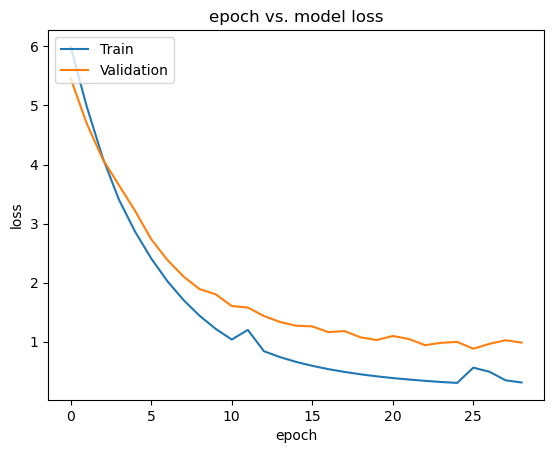

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[0.85034014 0.4516129 ]


In [17]:
leaky_relu_alpha = 0.001
earlystop = EarlyStopping(monitor='val_loss',min_delta=.003,patience=3)

model1 = Sequential(
    [
        Dense(units=3000, name = "L1", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        LeakyReLU(negative_slope=leaky_relu_alpha),
        Dropout(0.2),
        Dense(units=300, name = "L2", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        LeakyReLU(negative_slope=leaky_relu_alpha),
        Dropout(0.2),
        Dense(units=50, name = "L3", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        LeakyReLU(negative_slope=leaky_relu_alpha),
        Dense(units=2, activation = 'sigmoid', name = "L4")
    ]
)
model1.compile(
             loss=BinaryCrossentropy(),
             optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001,
                                               beta_1=.09,
                                               beta_2=0.999)
             )
history = model1.fit(
                 X_train_fit,Y_train_fit,
                 verbose=1,
                 epochs=100, 
                 batch_size=0, 
                 callbacks=earlystop,
                 validation_data=(X_train_eval, Y_train_eval)
             )
lossGraph(history)
Y_train_eval_pred = (model1.predict(X_train_eval) > 0.5).astype("int64")
Y_train_eval_pred = pd.DataFrame(Y_train_eval_pred, columns = ['ADHD_Outcome', 'Sex_F'])
f1score = f1_score(Y_train_eval, Y_train_eval_pred, average=None)
print(f1score)

In [18]:
participant_id = test_df['participant_id']
X_test = test_df.drop(columns = 'participant_id')
y_pred = (model1.predict(X_test) > 0.5).astype("int64")

predictions_df = pd.DataFrame(y_pred,columns=['Predicted_ADHD', 'Predicted_Sex'])
result_df = pd.concat([participant_id.reset_index(drop=True), predictions_df], axis=1) # put participant_id back in
print(result_df)
print(predictions_df.value_counts())

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
    participant_id  Predicted_ADHD  Predicted_Sex
0     Cfwaf5FX7jWK               1              0
1     vhGrzmvA3Hjq               1              1
2     ULliyEXjy4OV               1              1
3     LZfeAb1xMtql               1              1
4     EnFOUv0YK1RG               1              1
..             ...             ...            ...
299   UadZfjdEg7eG               1              1
300   IUEHiLmQAqCi               1              0
301   cRySmCadYFRO               1              1
302   E3MvDUtJadc5               1              0
303   dQJXfyRazknD               1              1

[304 rows x 3 columns]
Predicted_ADHD  Predicted_Sex
1               1                140
                0                131
0               0                 32
                1                  1
Name: count, dtype: int64


In [19]:
result_df.to_csv(path_or_buf='/mnt/c/Users/Robbie/Desktop/VSCode/WiDS/submission.csv', index=False)